# Preparing Data and Model Building

In [1]:
#workflow and statistics
import pandas as pd
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt

#for showing missing values
import missingno as msno

#visualisation
import seaborn as sns

#natural language processing toolkit
import nltk
import string
from nltk.corpus import stopwords  # removes useless words
from nltk.stem.lancaster import LancasterStemmer  #converts the words to base form; aggressive
from nltk.stem import porter
from nltk.stem.util import suffix_replace, prefix_replace
from nltk.stem.api import StemmerI
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')

#accessing google cloud storage
#from google.cloud import storage
#from io import BytesIO
#client = storage.Client()
#bucket = "bilderkennung_nf_2020"

#building baseline classifier
from sklearn.model_selection import train_test_split
import re
from tqdm import tqdm_notebook
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

import os
import glob

#evaluation metrics
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score

# Grid search cross validation
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.


In [2]:
# import data into GCP
#train_data = pd.read_csv("gs://bilderkennung_nf_2020/data /jigsaw-toxic-comment-train.csv")

In [3]:
val = pd.read_csv('./validation.csv')

In [4]:
val.shape

(8000, 4)

In [5]:
val.head()

,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


In [6]:
train = pd.read_csv('./jigsaw-toxic-comment-train.csv')

In [7]:
train.shape

(223549, 8)

In [8]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [9]:
df = train['toxic'].value_counts()

In [10]:
df.sort_values(0)

1     21384
0    202165
Name: toxic, dtype: int64

In [11]:
train['toxic'].shape

(223549,)

In [12]:
toxic = (48434/426707)*100
non_toxic = (378273/426707)*100
print(toxic, non_toxic)

11.350645759268069 88.64935424073192


In [13]:
toxic = 11.35
non_toxic = 88.65

In [14]:
data_ = {'toxic':[11.4], 'non-toxic':[88.9]}

In [15]:
rel_dist = pd.DataFrame.from_dict(data_)
rel_dist.transpose()

,0
toxic,11.4
non-toxic,88.9


In [16]:
import matplotlib.ticker as mtick

<Figure size 720x432 with 0 Axes>

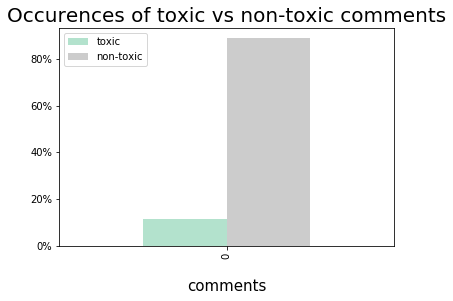

In [17]:
plt.figure(1,figsize=(10,6))
ax = rel_dist.plot(kind='bar', colormap='Pastel2')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Occurences of toxic vs non-toxic comments",fontsize=20)
#plt.ylabel('number of Occurrences', fontsize=15,labelpad=20)
plt.xlabel('comments', fontsize=15,labelpad=20)
plt.show()

As we can see in the plot above our comment classes are not of equal size and therefore our data needs rebalancing before executing any model on it.

**Prepare the model**

In the following steps, we will set the key model parameters and split the data.
- “MAX_NB_WORDS” sets the maximum number of words to consider as features for tokenizer.
- “MAX_SEQUENCE_LENGTH” cuts off texts after this number of words (among the MAX_NB_WORDS most common words).
- “VALIDATION_SPLIT” sets a portion of data for validation and not used in training.
- “EMBEDDING_DIM” defines the size of the “vector space”.
- “GLOVE_DIR” defines the GloVe file directory.
- Split the data into the texts and the labels.

In [18]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe)
#GLOVE_DIR = 


**Text Cleaning**

remove stopwords, punctuation and make everything lowercase:

In [ ]:
def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)
train['comment_text'] = train['comment_text'].apply(remove_punctuation)

In [ ]:
sw=stopwords.words('english')
def removesw(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)
train['comment_text'] = train['comment_text'].apply(removesw)

In [ ]:
stemmer = SnowballStemmer("english")

def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 
train['comment_text'] = train['comment_text'].apply(stemming)

 Have a look a sample data:

In [ ]:
#print('Sample data:',   )

### Prepare the Data

In [19]:
labels = ['toxic']
y = train[labels].values
comments_train = train['comment_text']
comments_val = val['comment_text']

In [20]:
comments_train = list(comments_train)

In [21]:
def clean_text(text, remove_stopwords = True):
    output = ""
    text = str(text).replace("\n", "")
    text = re.sub(r'[^\w\s]','',text).lower()
    if remove_stopwords:
        text = text.split(" ")
        for word in text:
            if word not in stopwords.words("english"):
                output = output + " " + word
    else:
        output = text
    return str(output.strip())[1:-3].replace("  ", " ")

In [22]:
texts = [] 

for line in tqdm_notebook(comments_train, total=159571): 
    texts.append(clean_text(line))

/Users/student/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
print('Sample data:', texts[1], y[1])

Sample data: aww matches background colour im seemingly stuck thanks talk 2151 january 11 2016  [0]


In [24]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

In [25]:
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 431032


In [26]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (223549, 200)
Shape of label tensor: (223549, 1)


In [27]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

In [28]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]

In [29]:
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [17032]
validation:  [4352]


In [30]:
print('Tokenized sentences: \n', data[10])
print('One hot label: \n', labels[10])

Tokenized sentences: 
 [ 6505    75    48    31   456     1   138  1900   863  1010  2615     5
   836  7215 28047    86   836   808  1788 21095  2013    46  2034   514
 11314  6120   524   330   389 17079  1328     1  1010  1110   524    45
  6919   106   352  1821    34   428 21033   818   345   140    23  9034
  6068  7817    21   257   171  4926  1062  4393  5759  1290   174   213
  3907  1871 48503     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0    

## Create the LSTM model

We will use pre-trained GloVe vectors from Stanford to create an index of words mapped to known embeddings, by parsing the data dump of pre-trained embeddings.
Then load word embeddings into an embeddings_index

In [31]:
embeddings_index = {}

#with open("GloVe/glove.6B/glove.6B.50d.txt", 'r') as f:
f= open("glove.6B.100d.txt","w+")
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Done.
 Proceeding with Embedding Matrix... Completed!


- Create the embedding layers.
- Specifies the maximum input length to the Embedding layer.
- Make use of the output from the previous embedding layer which outputs a 3-D tensor into the LSTM layer.
- Use a Global Max Pooling layer to to reshape the 3D tensor into a 2D one.
- We set the dropout layer to drop out 10% of the nodes.
- We define the Dense layer to produce a output dimension of 50.
- We feed the output into a Dropout layer again.
- Finally, we feed the output into a “Sigmoid” layer.

In [32]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)

In [33]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(1, activation="sigmoid")(x)

Its time to Compile the model into a static graph for training.
- Define the inputs, outputs and configure the learning process.
- Set the model to optimize our loss function using “Adam” optimizer, define the loss function to be “binary_crossentropy”

In [42]:
model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy', 'AUC'])

**Implementin EarlyStop and ModelCheckpoint for best model output**

In [43]:
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)
mc = ModelCheckpoint('best_LSTM_model.h5', monitor='val_accuracy', mode='auto', verbose=1, save_best_only=True)

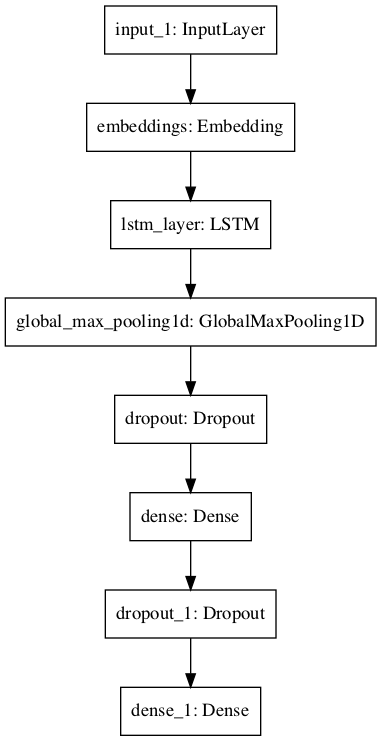

In [44]:
#visualize the model's architecture
tf.keras.utils.plot_model(model)

## Training

- Feed in a list of 32 padded, indexed sentence for each batch. The validation set will be used to assess whether the model has overfitted.
- The model will run for 2 epochs, because even 2 epochs is enough to overfit.

In [37]:
x_train.shape

(178840, 200)

In [38]:
x_val.shape

(44709, 200)

In [39]:
y_train.shape

(178840, 1)

In [40]:
y_val.shape

(44709, 1)

In [45]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 30, batch_size=32, validation_data=(x_val, y_val), verbose=1, callbacks=[es, mc])

Training progress:
Epoch 1/30
5588/5589 [============================>.] - ETA: 0s - loss: 0.2461 - accuracy: 0.9216 - auc: 0.7895
Epoch 00001: val_accuracy improved from -inf to 0.92990, saving model to best_LSTM_model.h5
5589/5589 [==============================] - 315s 56ms/step - loss: 0.2461 - accuracy: 0.9216 - auc: 0.7895 - val_loss: 0.2076 - val_accuracy: 0.9299 - val_auc: 0.8737
Epoch 2/30
5589/5589 [==============================] - ETA: 0s - loss: 0.2003 - accuracy: 0.9322 - auc: 0.8787
Epoch 00002: val_accuracy improved from 0.92990 to 0.93290, saving model to best_LSTM_model.h5
5589/5589 [==============================] - 333s 60ms/step - loss: 0.2003 - accuracy: 0.9322 - auc: 0.8787 - val_loss: 0.1973 - val_accuracy: 0.9329 - val_auc: 0.8981
Epoch 3/30
5589/5589 [==============================] - ETA: 0s - loss: 0.1859 - accuracy: 0.9362 - auc: 0.8985
Epoch 00003: val_accuracy improved from 0.93290 to 0.93529, saving model to best_LSTM_model.h5
5589/5589 [================

5589/5589 [==============================] - ETA: 0s - loss: 0.1316 - accuracy: 0.9503 - auc: 0.9568
Epoch 00024: val_accuracy did not improve from 0.94279
5589/5589 [==============================] - 533s 95ms/step - loss: 0.1316 - accuracy: 0.9503 - auc: 0.9568 - val_loss: 0.1694 - val_accuracy: 0.9416 - val_auc: 0.9256
Epoch 25/30
5589/5589 [==============================] - ETA: 0s - loss: 0.1294 - accuracy: 0.9512 - auc: 0.9586
Epoch 00025: val_accuracy did not improve from 0.94279
5589/5589 [==============================] - 511s 91ms/step - loss: 0.1294 - accuracy: 0.9512 - auc: 0.9586 - val_loss: 0.1630 - val_accuracy: 0.9421 - val_auc: 0.9294
Epoch 26/30
5589/5589 [==============================] - ETA: 0s - loss: 0.1282 - accuracy: 0.9519 - auc: 0.9593
Epoch 00026: val_accuracy did not improve from 0.94279
5589/5589 [==============================] - 355s 63ms/step - loss: 0.1282 - accuracy: 0.9519 - auc: 0.9593 - val_loss: 0.1701 - val_accuracy: 0.9417 - val_auc: 0.9260
Epoc

In [46]:
# load the saved model
saved_model = load_model('best_LSTM_model.h5')

## Evaluate the Model

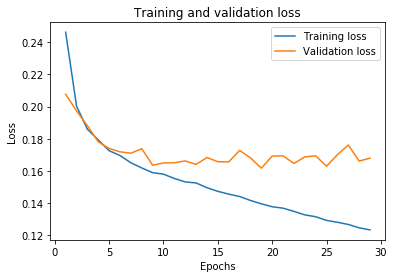

In [47]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

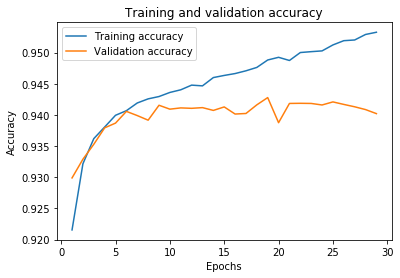

In [48]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

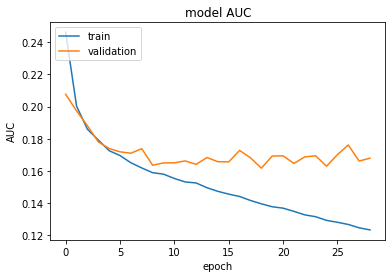

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()